# One Dimensional Kalman Filters

In [1]:
%matplotlib inline

In [2]:
#format the book
import book_format
book_format.set_style()

现在我们了解了离散贝叶斯滤波器和高斯滤波器，我们准备实现卡尔曼滤波器。我们将完全按照我们对离散贝叶斯滤波器所做的那样做——而不是从方程开始，我们将根据对问题的推理逐步开发代码。

“一维”意味着过滤器只跟踪一个状态变量，例如 x 轴上的位置。在随后的章节中，我们将学习一种更通用的多维形式的滤波器，它可以同时跟踪许多状态变量，例如位置、速度和加速度。回想一下，我们在 g-h 滤波器中使用速度来获得比单独跟踪位置更好的估计。卡尔曼滤波器也是如此。

那么为什么不直接跳入过滤器的多维形式呢？老实说，数学很困难，我开发过滤器的直观方法开始失效。这个数学模糊了允许卡尔曼滤波器工作的相当简单的原理。

因此，在本章中，我们将学习如何使用高斯函数来实现贝叶斯滤波器。这就是卡尔曼滤波器的全部内容 - 一个使用高斯的贝叶斯滤波器。在下一章中，我们将切换到多维形式，卡尔曼滤波器的全部威力将被释放！

## Problem Description



正如在**离散贝叶斯滤波器**一章中一样，我们将在工作的长走廊中跟踪一个移动的物体。假设在我们最近的黑客马拉松中，有人创建了一个 RFID 跟踪器，可以提供狗的相当准确的位置。传感器返回狗与走廊左端的距离（以米为单位）。因此，23.4 意味着狗距离走廊的左端 23.4 米。

传感器并不完美。读数为 23.4 可能对应于狗的读数为 23.7 或 23.0。但是，它不太可能对应于 47.6 的位置。黑客马拉松期间的测试证实了这一结果——传感器“相当”准确，虽然它有错误，但错误很小。此外，误差似乎均匀分布在真实位置的两侧； 23 m 的位置同样可能被测量为 22.9 或 23.1。也许我们可以用高斯模型来模拟它。

我们预测狗在移动。这个预测并不完美。有时我们的预测会过冲，有时会过冲。我们更有可能低于或超过很多。也许我们也可以用高斯来建模。

## Beliefs as Gaussians

我们可以用高斯表达我们对狗位置的信念。 假设我们相信我们的狗在 10 米处，并且该信念的方差是 1 m$^2$，或 $\mathcal{N}(10,\, 1)$。 pdf的情节如下：

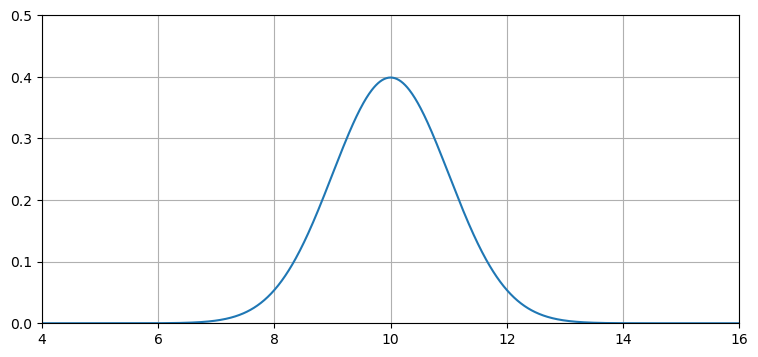

In [4]:
import filterpy.stats as stats
stats.plot_gaussian_pdf(mean=10., variance=1., 
                        xlim=(4, 16), ylim=(0, .5));


该图描述了我们对狗位置的不确定性。 它代表了一种相当不准确的信念。 虽然我们认为狗最有可能在 10 m 处，但从 9 m 到 11 m 左右的任何位置也很有可能。 假设狗静止不动，我们再次查询传感器。 这次它返回 10.2 m。 我们可以使用这些额外的信息来改进我们的估计吗？

直觉表明我们可以。 考虑一下：如果我们读取传感器 500 次，每次它返回一个介于 8 和 12 之间的值，都以 10 为中心，我们应该非常确信狗接近 10。当然，可以有不同的解释。 也许我们的狗以一种完全模仿正态分布的随机抽取的方式随机地来回游荡。 但这似乎极不可能——我从未见过狗这样做。 让我们看一下 $\mathcal N(10, 1)$ 的 500 次抽奖：

Mean of readings is 10.000


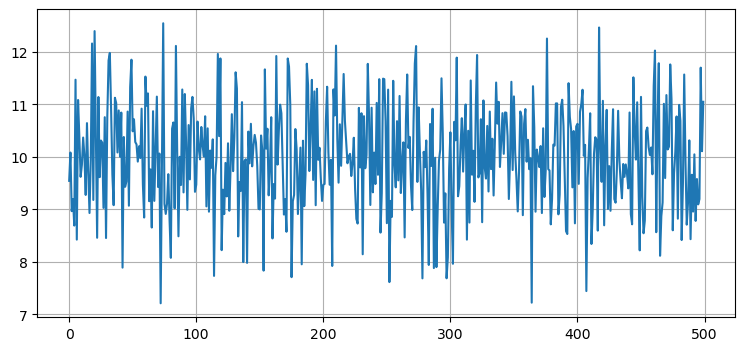

In [7]:
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt

xs = range(500)
ys = randn(500)*1. + 10.
plt.plot(xs, ys)
print(f'Mean of readings is {np.mean(ys):.3f}')

目测这证实了我们的直觉——没有狗像这样移动。 然而，嘈杂的传感器数据肯定是这样的。 读数的计算平均值几乎正好是 10。假设狗静止不动，我们说狗在位置 10，方差为 1。

## Tracking with Gaussian Probabilities

离散贝叶斯滤波器使用概率直方图来跟踪狗。 直方图中的每个 bin 代表一个位置，值是狗处于该位置的概率。

跟踪是通过一个预测和更新周期进行的。 我们使用了方程

$$\begin{aligned} 
\bar {\mathbf x} &= \mathbf x \ast f_{\mathbf x}(\bullet)\, \, &\text{Predict} \\
\mathbf x &= \mathcal L \cdot \bar{\mathbf x}\, \, &\text{Update}
\end{aligned}$$

计算新的概率分布。 回想一下 $\bar{\mathbf x}$ 是*先验*，$\mathcal L$ 是给定先验 $\bar{\mathbf x}$, $f_{\mathbf x} 的测量的*似然性* (\bullet)$ 是*过程模型*，$\ast$ 表示*卷积*。 $\mathbf x$ 用粗体表示它是一个数字的直方图，或者一个向量。

这种方法有效，但导致的直方图暗示狗可能同时在多个地方。 此外，对于大型问题，计算速度非常慢。

我们可以用高斯 $\mathcal N(x, \sigma^2)$ 替换直方图 $\mathbf x$ 吗？ 绝对地！ 我们已经学会了如何将信念表达为高斯。 一个高斯，它是单个数字对 $\mathcal N(\mu, \sigma^2),$ 可以替换整个概率直方图：

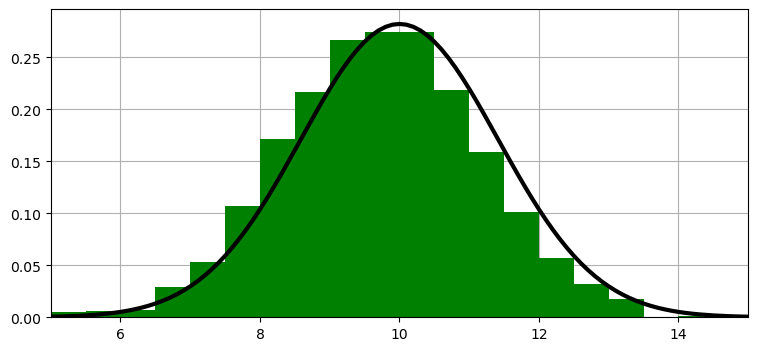

In [8]:
import kf_book.kf_internal as kf_internal
kf_internal.gaussian_vs_histogram()

我希望你能看到它的力量。 我们可以用一对数字替换成百上千个数字：

$x = \mathcal N(\mu, \sigma^2)$。

高斯的尾部在两侧延伸到无穷大，因此它在直方图中包含任意多个条形。 如果这代表我们对狗在走廊中的位置的信念，那么这个高斯覆盖了整个走廊（以及该轴上的整个宇宙）。 我们认为这只狗很可能是 10 岁，但他可能是 8 岁、14 岁，或者，以极小的概率，在 10$^{80}$。

在本章中，我们将直方图替换为高斯图：

$$\begin{array}{l|l|c}
\text{discrete Bayes} & \text{Gaussian} & \text{Step}\\
\hline
\bar {\mathbf x} = \mathbf x \ast f(\mathbf x) & 
\bar {x}_\mathcal{N} =  x_\mathcal{N} \, \oplus \, f_{x_\mathcal{N}}(\bullet) &
\text{Predict} \\
\mathbf x = \|\mathcal L \bar{\mathbf x}\| & x_\mathcal{N} = L \, \otimes \, \bar{x}_\mathcal{N} & \text{Update} 
\end{array}$$

其中 $\oplus$ 和 $\otimes$ 是为了表达一些未知的高斯算子。 在本书的其余部分我不会这样做，但下标表明 $x_\mathcal{N}$ 是高斯的。

离散贝叶斯滤波器使用卷积进行预测。 我们展示了它使用*总概率定理*，计算为和，所以也许我们可以添加高斯。 它使用乘法将测量值合并到先验中，所以也许我们可以乘以高斯。 会不会这么简单：

$$\begin{aligned} 
\bar x &\stackrel{?}{=} x + f_x(\bullet) \\
x &\stackrel{?}{=} \mathcal L \cdot \bar x
\end{aligned}$$

这仅在两个高斯的和和乘积是另一个高斯时才有效。 否则，在第一个 epoch 之后，$x$ 就不是高斯的了，这个方案就分崩离析了。

## Predictions with Gaussians

我们使用牛顿运动方程根据当前速度和先前位置计算当前位置：

$$ \begin{aligned}\bar{x}_k &= x_{k-1} + v_k \Delta t \\
 &= x_{k-1} + f_x\end{aligned}$$
 
我已经放弃了符号 $f x(\bullet)$ 以支持 $f x$ 以保持方程整洁。
如果狗在 10 m，他的速度是 15 m/s，epoch 是 2 秒长，我们有

$$ \begin{aligned} f_x &= v\Delta t = 15\cdot 2\\
\bar{x}_k &= 10 + (15\cdot 2) = 40 \end{aligned}$$

我们不确定他当前的位置和速度，所以不会这样做。 我们需要用高斯表示不确定性。

位置很容易。 我们将 $x$ 定义为高斯。 如果我们认为狗在 10 m，我们不确定性的标准差是 0.2 m，我们得到 $x=\mathcal N(10, 0.2^2)$。

我们对他的运动的不确定性呢？ 我们将 $f_x$ 定义为高斯。 如果狗的速度是 15 m/s，epoch 是 1 秒，我们不确定性的标准差是 0.7 m/s，我们得到 $f_x = \mathcal N (15, 0.7^2)$。

先验方程是

$$\bar x = x + f_x$$


两个高斯的和是多少？ 在上一章中，我证明了：

$$\begin{gathered}
\mu = \mu_1 + \mu_2 \\
\sigma^2 = \sigma^2_1 + \sigma^2_2
\end{gathered}$$

这是个好消息； 两个高斯的和是另一个高斯！

数学有效，但这是否具有直观意义？ 想想这个抽象方程的物理表示。 我们有

$$\begin{gathered}
x=\mathcal N(10, 0.2^2)\\
f_x = \mathcal N (15, 0.7^2)
\end{gathered}$$

如果我们添加这些，我们会得到：

$$\begin{aligned}\bar x &= \mu_x + \mu_{f_x} = 10 + 15 &&= 25 \\
\bar\sigma^2 &= \sigma_x^2 + \sigma_{f_x}^2 = 0.2^2 + 0.7^2 &&= 0.53\end{aligned}$$

预测位置是前一个位置加上运动是有道理的。方差怎么办？对此很难形成直觉。然而，回想一下，使用离散贝叶斯滤波器的“predict()”函数，我们总是会丢失信息。我们真的不知道狗在哪里移动，所以信心应该变小（方差变大）。 $\sigma_{f_x}^2$ 是由于对运动的不完美预测而添加到系统中的不确定性数量，因此我们会将其添加到现有的不确定性中。

让我们利用 Python 的 `collection` 模块中的 `namedtuple` 类来实现一个高斯对象。我们可以使用元组来实现高斯分布，其中 $\mathcal N(10, 0.04)$ 在 Python 中实现为 `g = (10., 0.04)`。我们将使用“g[0]”获取均值，使用“g[1]”获取方差。

`namedtuple` 的工作方式与元组相同，只是您为它提供了类型名称和字段名称。理解并不重要，但我修改了 __repr__ 方法以使用本章中的符号显示其值。

In [9]:
from collections import namedtuple
gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: '𝒩(μ={:.3f}, 𝜎²={:.3f})'.format(s[0], s[1])

现在我们可以创建一个高斯打印：

In [17]:
g1 = gaussian(3.4, 10.1)
g2 = gaussian(mean=4.5, var=0.2**2)
print(g1)
print(g2)

𝒩(μ=3.400, 𝜎²=10.100)
𝒩(μ=4.500, 𝜎²=0.040)


我们可以使用下标或字段名称访问均值和方差：

In [18]:
g1.mean, g1[0], g1[1], g1.var

(3.4, 3.4, 10.1, 10.1)

这是我们对预测函数的实现，其中`pos`和`movement`是形式为($\mu$, $\sigma^2$)的高斯元组：

In [19]:
def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)

让我们测试一下。 初始位置的先验是高斯$\mathcal N(10, 0.2^2)$，运动是高斯$\mathcal N(15, 0.7^2)$？

In [20]:
pos = gaussian(10., .2**2)
move = gaussian(15., .7**2)
predict(pos, move)

𝒩(μ=25.000, 𝜎²=0.530)

先验表明狗在 25 m 处，方差为 0.53 m$^2$，这是我们手动计算的。

## Updates with Gaussians

离散贝叶斯滤波器在概率直方图中编码了我们对狗位置的信念。 分布是离散的和多模式的。 它可以表达强烈的信念，即狗同时处于两个位置，并且位置是离散的。

我们建议用高斯替换直方图。 离散贝叶斯滤波器使用此代码来计算后验：

```python
def update(likelihood, prior):
    posterior = likelihood * prior
    return normalize(posterior)
```

这是等式的实现：

$$x = \| \mathcal L\bar x \|$$

我们刚刚展示了我们可以用高斯表示先验。 可能性如何？ 可能性是给定当前状态的测量概率。 我们已经学会了如何将测量值表示为高斯。 例如，也许我们的传感器指出狗在 23 m 处，标准偏差为 0.4 米。 我们的测量，表示为可能性，是 $z = \mathcal N (23, 0.16)$。

可能性和先验都是用高斯模型建模的。 我们可以乘以高斯吗？ 两个高斯的乘积是另一个高斯吗？

是的，对前者，几乎对后者！ 在上一章中，我证明了两个高斯的乘积与另一个高斯成正比。

$$\begin{aligned}
\mu &= \frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2}, \\
\sigma^2 &= \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2}
\end{aligned}$$

我们可以立即推断出几件事。 如果我们对结果进行归一化，则乘积是另一个高斯。 如果一个高斯是可能性，第二个是先验，则均值是先验和测量值的缩放和。 方差是先验方差和测量方差的组合。 最后，方差完全不受均值的影响！

我们把它放在贝叶斯术语中，如下所示：

$$\begin{aligned}
\mathcal N(\mu, \sigma^2) &= \| prior \cdot likelihood \|\\
&= \| \mathcal{N}(\bar\mu, \bar\sigma^2)\cdot \mathcal{N}(\mu_z, \sigma_z^2) \|\\
&= \mathcal N(\frac{\bar\sigma^2 \mu_z + \sigma_z^2 \bar\mu}{\bar\sigma^2 + \sigma_z^2},\frac{\bar\sigma^2\sigma_z^2}{\bar\sigma^2 + \sigma_z^2})
\end{aligned}$$

如果我们在函数 `gaussian_multiply()` 中实现它，我们可以将过滤器的更新步骤实现为

In [21]:
def gaussian_multiply(g1, g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    variance = (g1.var * g2.var) / (g1.var + g2.var)
    return gaussian(mean, variance)

def update(prior, likelihood):
    posterior = gaussian_multiply(likelihood, prior)
    return posterior

# test the update function
predicted_pos = gaussian(10., .2**2)
measured_pos = gaussian(11., .1**2)
estimated_pos = update(predicted_pos, measured_pos)
estimated_pos

𝒩(μ=10.800, 𝜎²=0.008)

如果我们使用更具体的名称，这可能会更清楚：

```python
def update_dog(dog_pos, measurement):
    estimated_pos = gaussian_multiply(measurement, dog_pos)
    return estimated_pos  
```

这不那么抽象，这可能有助于理解，但它是糟糕的编码实践。 我们正在编写一个适用于任何问题的卡尔曼滤波器，而不仅仅是在走廊里跟踪狗，所以我们不会使用其中包含“狗”的变量名。 此外，这种形式掩盖了我们将可能性乘以先验的事实。

我们已经实现了大部分过滤器，但我担心这一步仍然有点混乱。 我已经断言我们可以乘以高斯并且它正确地执行了更新步骤，但为什么这是真的？ 让我们绕道而行，花一些时间乘以高斯。

### Understanding Gaussian Multiplication

让我们绘制 $\mathcal{N}(10,\, 1) \times \mathcal{N}(10,\, 1)$ 的 pdf。 你能不看结果就确定它的形状吗？ 新的意思应该是什么？ 曲线会变宽、变窄还是与 $\mathcal{N}(10,\, 1)$ 相同？

𝒩(μ=10.000, 𝜎²=0.500)


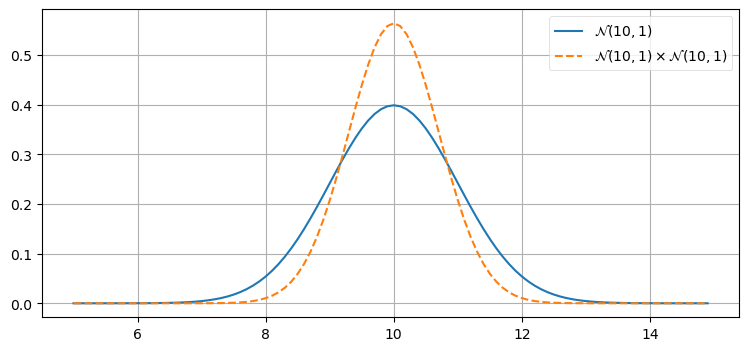

In [22]:
z = gaussian(10., 1.)  # Gaussian N(10, 1)

product = gaussian_multiply(z, z)

xs = np.arange(5, 15, 0.1)
ys = [stats.gaussian(x, z.mean, z.var) for x in xs]
plt.plot(xs, ys, label='$\mathcal{N}(10,1)$')

ys = [stats.gaussian(x, product.mean, product.var) for x in xs]
plt.plot(xs, ys, label='$\mathcal{N}(10,1) \\times \mathcal{N}(10,1)$', ls='--')
plt.legend()
print(product)

乘法的结果比原始的高斯更高更窄，但平均值没有变化。 这符合你的直觉吗？

将高斯人视为两个测量值。 如果我测量两次，每次得到 10 米，我应该得出结论，长度接近 10 米。 因此平均值应该是 10。得出长度实际上是 11 或 9.5 的结论是没有意义的。 此外，我对两次测量比一次测量更有信心，因此结果的方差应该更小。

“测量两次，切割一次”是一句众所周知的谚语。 高斯乘法是这个物理事实的数学模型。

我不太可能连续两次获得相同的测量值。 现在让我们绘制 $\mathcal{N}(10.2,\, 1) \times \mathcal{N}(9.7,\, 1)$ 的 pdf。 你认为结果会是什么？ 想一想，然后看图表。

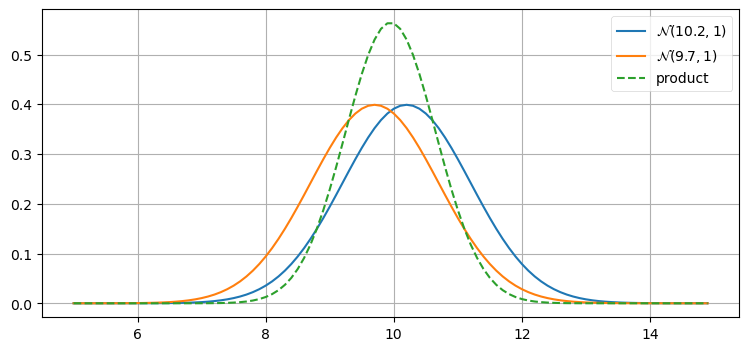

In [23]:
def plot_products(g1, g2): 
    plt.figure()
    product = gaussian_multiply(g1, g2)

    xs = np.arange(5, 15, 0.1)
    ys = [stats.gaussian(x, g1.mean, g1.var) for x in xs]
    plt.plot(xs, ys, label='$\mathcal{N}$'+'$({},{})$'.format(g1.mean, g1.var))

    ys = [stats.gaussian(x, g2.mean, g2.var) for x in xs]
    plt.plot(xs, ys, label='$\mathcal{N}$'+'$({},{})$'.format(g2.mean, g2.var))

    ys = [stats.gaussian(x, product.mean, product.var) for x in xs]
    plt.plot(xs, ys, label='product', ls='--')
    plt.legend();
    
z1 = gaussian(10.2, 1)
z2 = gaussian(9.7, 1)
 
plot_products(z1, z2)

如果你让两个人测量一张桌子到墙壁的距离，一个人得到 10.2 米，另一个得到 9.7 米，你最好的猜测一定是平均值，如果你同样相信两人的技能，你的最佳猜测是 9.95 米。

回想一下 g-h 过滤器。我们一致认为，如果我用两个秤称自己的体重，第一个称 160 磅，第二个称 170 磅，并且两者都同样准确，那么最好的估计是 165 磅。此外，我应该对 165 磅与 160 磅或 170 磅更有信心，因为我现在有两个读数，都接近这个估计值，这增加了我对两者都不是错误的信心。

这在更复杂的情况下变得违反直觉，所以让我们进一步考虑。也许一个更合理的假设是一个人犯了一个错误，真实的距离不是 10.2 就是 9.7，但肯定不是 9.95。这当然是可能的。但是我们知道我们有嘈杂的测量，所以我们没有理由认为其中一个测量没有噪音，或者有人犯了一个严重的错误，让我们放弃了他们的测量。鉴于所有可用信息，最佳估计值必须为 9.95。

在卡尔曼滤波器的更新步骤中，我们没有组合两个测量值，而是一个测量值和一个先验值，即我们在合并测量值之前的估计。我们为 g-h 过滤器完成了这个逻辑。不管我们是合并来自两个测量的信息，还是一个测量和一个预测，数学都是一样的。

让我们看看。我将创建一个相当不准确的先验 $\mathcal N(8.5, 1.5)$ 和一个更准确的测量 $\mathcal N(10.2, 0.5)。$ “准确”是指传感器方差小于先验方差，并不是说我不知何故知道这只狗比 8.5 更接近 10.2。接下来我将绘制相反的关系：$\mathcal N(8.5, 0.5)$ 的准确先验和 $\mathcal N(10.2, 1.5)$ 的不准确测量。

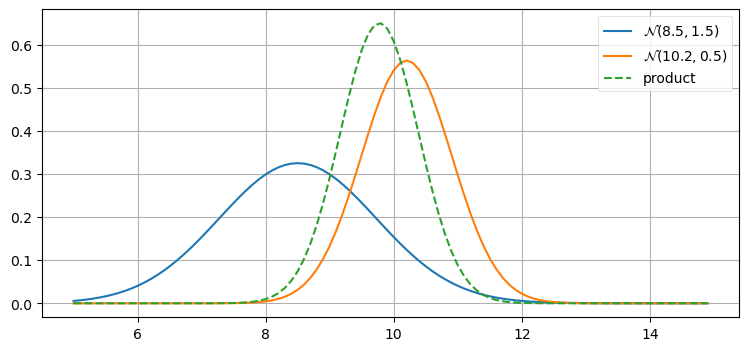

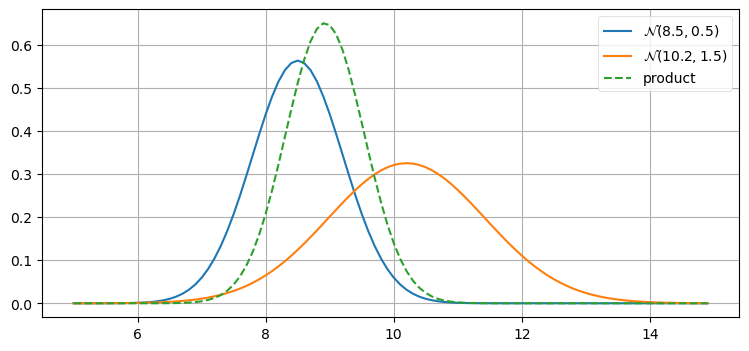

In [24]:
prior, z = gaussian(8.5, 1.5), gaussian(10.2, 0.5)
plot_products(prior, z)

prior, z = gaussian(8.5, 0.5), gaussian(10.2, 1.5)
plot_products(prior, z)

结果是一个比任一输入都高的高斯分布。 这是有道理的——我们已经合并了信息，所以我们的方差应该已经减少了。 并注意结果如何更接近方差较小的输入。 我们对这个价值更有信心，所以更重地衡量它是有意义的。

它*似乎*有效，但它真的正确吗？ 关于这一点还有很多话要说，但我想让一个有效的过滤器运行起来，这样你就可以具体地体验它。 之后，我们将重新审视高斯乘法并确定它为什么是正确的。

### Interactive Example

这个交互式代码提供了滑块来改变被相乘的两个高斯的均值和方差。 当您移动滑块时，会重新绘制绘图。 将光标放在代码单元格内，然后按 CTRL+Enter 执行它。

In [25]:
from ipywidgets import interact

def interactive_gaussian(m1, m2, v1, v2):
    g1 = gaussian(m1, v1)
    g2 = gaussian(m2, v2)
    plot_products(g1, g2)
    
interact(interactive_gaussian,
         m1=(5, 10., .5), m2=(10, 15, .5), 
         v1=(.1, 2, .1), v2=(.1, 2, .1));

interactive(children=(FloatSlider(value=7.5, description='m1', max=10.0, min=5.0, step=0.5), FloatSlider(value…

结果是一个比任一输入都高的高斯分布。 这是有道理的——我们已经合并了信息，所以我们的方差应该已经减少了。 并注意结果如何更接近方差较小的输入。 我们对这个价值更有信心，所以更重地衡量它是有意义的。

它*似乎*有效，但它真的正确吗？ 关于这一点还有很多话要说，但我想让一个有效的过滤器运行起来，这样你就可以具体地体验它。 之后，我们将重新审视高斯乘法并确定它为什么是正确的。

### Interactive Example

这个交互式代码提供了滑块来改变被相乘的两个高斯的均值和方差。 当您移动滑块时，会重新绘制绘图。 将光标放在代码单元格内，然后按 CTRL+Enter 执行它。

In [11]:
from ipywidgets import interact

def interactive_gaussian(m1, m2, v1, v2):
    g1 = gaussian(m1, v1)
    g2 = gaussian(m2, v2)
    plot_products(g1, g2)
    
interact(interactive_gaussian,
         m1=(5, 10., .5), m2=(10, 15, .5), 
         v1=(.1, 2, .1), v2=(.1, 2, .1));

interactive(children=(FloatSlider(value=7.5, description='m1', max=10.0, min=5.0, step=0.5), FloatSlider(value…

## First Kalman Filter

让我们回到具体的术语并实现卡尔曼滤波器。 我们已经实现了 `update()` 和 `predict()` 函数。 我们只需要编写一些样板代码来模拟狗并创建测量值。 我在 `kf_internal` 中放置了一个 `DogSimulation` 类，以避免因该任务而分心。

此样板代码通过定义均值、方差和生成模拟的狗运动来设置问题。

In [20]:
import kf_book.kf_internal as kf_internal
from kf_book.kf_internal import DogSimulation

np.random.seed(13)

process_var = 1. # variance in the dog's movement
sensor_var = 2. # variance in the sensor

x = gaussian(0., 20.**2)  # dog's position, N(0, 20**2)
velocity = 1
dt = 1. # time step in seconds
process_model = gaussian(velocity*dt, process_var) # displacement to add to x
  
# simulate dog and get measurements
dog = DogSimulation(
    x0=x.mean, 
    velocity=process_model.mean, 
    measurement_var=sensor_var, 
    process_var=process_model.var)

# create list of measurements
zs = [dog.move_and_sense() for _ in range(10)]

这是卡尔曼滤波器。

In [21]:
print('PREDICT\t\t\tUPDATE')
print('     x      var\t\t  z\t    x      var')

# perform Kalman filter on measurement z
for z in zs:    
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)

    kf_internal.print_gh(prior, x, z)

print()
print('final estimate:        {:10.3f}'.format(x.mean))
print('actual final position: {:10.3f}'.format(dog.x))

PREDICT			UPDATE
     x      var		  z	    x      var
  1.000  401.000	1.354	  1.352   1.990
  2.352    2.990	1.882	  2.070   1.198
  3.070    2.198	4.341	  3.736   1.047
  4.736    2.047	7.156	  5.960   1.012
  6.960    2.012	6.939	  6.949   1.003
  7.949    2.003	6.844	  7.396   1.001
  8.396    2.001	9.847	  9.122   1.000
 10.122    2.000	12.553	 11.338   1.000
 12.338    2.000	16.273	 14.305   1.000
 15.305    2.000	14.800	 15.053   1.000

final estimate:            15.053
actual final position:     14.838


这是过滤器的动画。 预测用红色三角形绘制。 在预测之后，过滤器接收下一个测量值，绘制为黑色圆圈。 然后过滤器在两者之间形成估计部分。

In [22]:
from kf_book import book_plots as book_plots
from ipywidgets.widgets import IntSlider

# save output in these lists for plotting
xs, predictions = [], []

process_model = gaussian(velocity, process_var) 

# perform Kalman filter
x = gaussian(0., 20.**2)
for z in zs:    
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)

    # save results
    predictions.append(prior.mean)
    xs.append(x.mean)

def plot_filter(step):
    plt.cla()
    step -= 1
    i = step // 3 + 1
 
    book_plots.plot_predictions(predictions[:i])    
    if step % 3 == 0:
        book_plots.plot_measurements(zs[:i-1])
        book_plots.plot_filter(xs[:i-1])
    elif step % 3 == 1:
        book_plots.plot_measurements(zs[:i])
        book_plots.plot_filter(xs[:i-1])
    else:
        book_plots.plot_measurements(zs[:i])
        book_plots.plot_filter(xs[:i])

    plt.xlim(-1, 10)
    plt.ylim(0, 20)
    plt.legend(loc=2);
interact(plot_filter, step=IntSlider(value=1, min=1, max=len(predictions)*3));

interactive(children=(IntSlider(value=1, description='step', max=30, min=1), Output()), _dom_classes=('widget-…

我已经绘制了先验（标记为 *prediction*）、测量值和滤波器输出。 对于循环的每次迭代，我们形成先验，进行测量，从测量中形成可能性，然后将可能性合并到先验中。

如果您查看该图，您会发现滤波器估计值始终介于测量值和预测值之间。 回想一下，对于 g-h 滤波器，我们认为估计值必须始终介于测量值和先验值之间。 在这两个值之外选择一个值是没有意义的。 如果我预测我在 10 岁，但测量我在 9 岁，那么决定我必须在 8 岁或 11 岁是愚蠢的。

## Code Walkthrough

现在让我们看一下代码。

```python
process_var = 1.
sensor_var = 2.
```

这些是过程模型和传感器的差异。 传感器方差的含义应该很清楚 - 它是每次测量中有多少方差。 过程方差是过程模型中有多少误差。 我们预测，在每一步，狗都会向前移动一米。 狗很少做我们所期望的事情，山丘或松鼠的气味会改变他的进步。 如果这是一个响应数字命令的机器人，性能会好得多，也许方差为 $\sigma^2=.05$。 这些不是“神奇”数字； 方差的平方根是以米为单位的距离误差。 只需插入数字就很容易使卡尔曼滤波器工作，但如果数字不能反映现实，那么滤波器的性能就会很差。

```python
x = gaussian(0., 20.**2)
```

这是狗的初始位置，用高斯表示。 位置为 0 米，方差为 400 m$^2$，即 20 米的标准差。 您可以将其理解为“我相信以 99.7% 的准确度，该位置是 0 正负 60 米”。 这是因为对于高斯，约 99.7% 的值落在均值的 $\pm3\sigma$ 内。

```python
process_model = gaussian(velocity, process_var)
```


这就是过程模型——描述我们认为狗是如何移动的。 我怎么知道速度？ 魔法？ 将其视为一种预测，或者我们可能有一个辅助速度传感器。 如果这是机器人，那么这将是机器人的控制输入。 在随后的章节中，我们将学习如何处理没有速度传感器或输入的情况，所以现在请接受这个简化。

接下来我们初始化模拟并创建 10 个测量值：

```python
dog = DogSimulation(
    x0=x.mean, 
    velocity=process_model.mean, 
    measurement_var=sensor_var, 
    process_var=process_model.var)

zs = [dog.move_and_sense() for _ in range(10)]
```

现在我们进入我们的 `predict() ... update()` 循环。


```python
for z in zs:
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)
```

第一次通过循环 `prior` 是 `(1.0, 401.0)`，从打印表中可以看出。在预测之后，我们认为我们处于 1.0，方差现在是 401，从 400 上升。方差变得更糟，这在预测步骤中总是发生，因为它涉及信息丢失。

然后我们使用 `prior` 作为当前位置调用更新函数。

为此，我得到以下结果：`pos = (1.352, 1.990), z = 1.354`。

怎么了？狗实际上是 1.0，但由于传感器噪声，测得的位置是 1.354。这与预测值 1 相差甚远。先验方差为 401 m$^2$。较大的方差意味着置信度非常低，因此过滤器估计位置非常接近测量值：1.352。

现在看看方差：1.99 m$^2$。它从 4.01 亿美元 ^2 美元大幅下降。为什么？好吧，RFID 的方差相当小，只有 2.0 m$^2$，所以我们比以前更信任它。然而，之前的信念确实包含一些有用的信息，所以我们的方差现在略小于 2.0。

现在软件循环，依次调用`predict()`和`update()`。 到最后，最终估计头寸为 15.053，而实际头寸为 14.838。 方差已收敛到 1.0 m$^2$。

现在看剧情。 噪声测量值用黑色圆圈绘制，过滤器结果用蓝色实线绘制。 两者都很嘈杂，但请注意测量结果的嘈杂程度。 我用红色三角形绘制了预测（先验）。 估计值总是介于先验值和测量值之间。 这是您的第一个卡尔曼滤波器，它似乎有效！

过滤仅在几行代码中实现。 大部分代码要么是初始化，要么是存储数据，要么是模拟狗的运动，要么是打印结果。 执行过滤的代码非常简洁：

```python
prior = predict(x, process_model)
likelihood = gaussian(z, sensor_var)
x = update(prior, likelihood)
```

如果我们不使用 `predict` 和 `update` 函数，代码可能是：


```python
for z in zs:
    # predict
    dx = velocity*dt
    pos = pos + dx
    var = var + process_var

    # update
    pos  = (var*z + sensor_var*pos) / (var + sensor_var)
    var = (var * sensor_var) / (var + sensor_var)
``` 

只需 5 行非常简单的数学运算即可实现整个过滤器！

在这个例子中，我只绘制了 10 个数据点，因此 print 语句的输出不会让我们不知所措。 现在让我们用更多数据来看看过滤器的性能。 方差被绘制为虚线之间的浅黄色阴影区域。 我增加了过程和传感器方差的大小，以便在图表上更容易看到它们 - 对于真正的卡尔曼滤波器，当然您不会随机更改这些值。

	4.4502 2.6507 2.2871 2.1955 2.1712
	2.1647 2.1629 2.1625 2.1623 2.1623
	2.1623 2.1623 2.1623 2.1623 2.1623
	2.1623 2.1623 2.1623 2.1623 2.1623
	2.1623 2.1623 2.1623 2.1623 2.1623


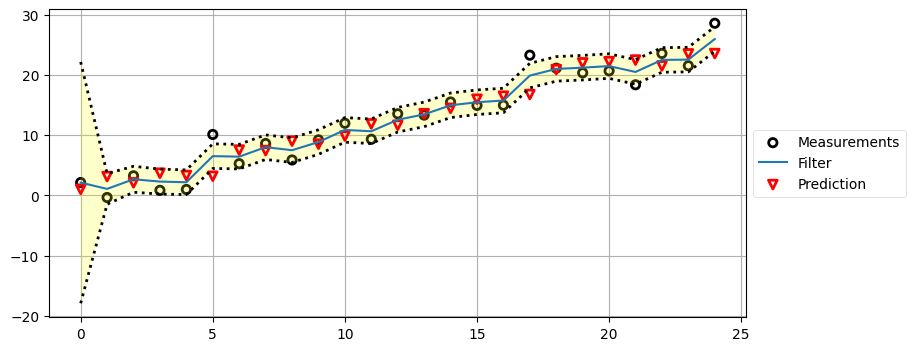

In [20]:
process_var = 2.
sensor_var = 4.5
x = gaussian(0., 400.)
process_model = gaussian(1., process_var)
N = 25

dog = DogSimulation(x.mean, process_model.mean, sensor_var, process_var)
zs = [dog.move_and_sense() for _ in range(N)]

xs, priors = np.zeros((N, 2)), np.zeros((N, 2))
for i, z in enumerate(zs):
    prior = predict(x, process_model)    
    x = update(prior, gaussian(z, sensor_var))
    priors[i] = prior
    
    xs[i] = x

book_plots.plot_measurements(zs)
book_plots.plot_filter(xs[:, 0], var=priors[:, 1])
book_plots.plot_predictions(priors[:, 0])
book_plots.show_legend()
kf_internal.print_variance(xs)

在这里我们可以看到方差分 9 步收敛到 2.1623。 这意味着我们对我们的位置估计变得非常有信心。 它等于 $\sigma=1.47$ 米。 将此与传感器的 $\sigma=2.12$ 米进行对比。 由于我们对初始位置的不确定性，前几次测量结果不确定，但滤波器很快收敛到方差低于传感器的估计值！

此代码完全实现了卡尔曼滤波器。 如果您尝试阅读文献，您可能会感到惊讶，因为这看起来与那些书中无尽的数学页面完全不同。 只要我们担心*使用*方程而不是*推导*它们，这个话题就很容易接近。 此外，我希望你会同意你对正在发生的事情有一个不错的直观把握。 我们用高斯表示信念，随着时间的推移它们会变得更好，因为更多的测量意味着我们有更多的数据可以使用。

### Exercise: Modify Variance Values

修改 `process_var` 和 `sensor_var` 的值并注意对过滤器和方差的影响。 哪个对方差收敛的影响更大？ 例如，这会导致较小的方差：


```python
process_var = 40
sensor_var = 2
```
    
or:

```python
process_var = 2
sensor_var = 40
```

### KF Animation

如果您在浏览器中阅读此内容，您将能够在这句话正下方看到过滤器跟踪狗的动画。

<img src='animations/05_dog_track.gif'>

上图以绿色显示滤波器的输出，用红色虚线显示测量值。 底部图显示了每一步的高斯分布。

当轨道第一次开始时，您可以看到测量结果与最初的预测相差很大。 在这一点上，高斯概率很小（曲线又低又宽），所以滤波器不相信它的预测。 结果，过滤器会大量调整其估计值。 随着滤波器的创新，您可以看到随着高斯变得更高，表明估计的确定性更高，滤波器的输出变得非常接近直线。 在“x = 15”或更大时，您可以看到测量中存在大量噪声，但与第一次噪声测量的变化相比，滤波器对其反应不大。

## Kalman Gain

我们看到过滤器有效。 现在让我们回到数学来了解正在发生的事情。 后验 $x$ 计算为似然乘以先验 ($\mathcal L \bar x$)，其中两者都是高斯分布。

因此后验的平均值由下式给出：

$$
\mu=\frac{\bar\sigma^2\, \mu_z + \sigma_z^2 \, \bar\mu} {\bar\sigma^2 + \sigma_z^2}
$$

我使用下标 $z$ 来表示测量值。 我们可以将其重写为：

$$\mu = \left( \frac{\bar\sigma^2}{\bar\sigma^2 + \sigma_z^2}\right) \mu_z + \left(\frac{\sigma_z^2}{\bar\sigma^2 + \sigma_z^2}\right)\bar\mu$$


在这种形式中，很容易看出我们正在按权重缩放测量值和先验值

$$\mu = W_1 \mu_z + W_2 \bar\mu$$


权重总和为 1，因为分母是归一化项。 我们引入一个新术语，$K=W_1$，给我们：

$$\begin{aligned}
\mu &= K \mu_z + (1-K) \bar\mu\\
&= \bar\mu + K(\mu_z - \bar\mu)
\end{aligned}$$

where

$$K = \frac {\bar\sigma^2}{\bar\sigma^2 + \sigma_z^2}$$

$K$ 是*卡尔曼增益*。 这是卡尔曼滤波器的关键。 它是一个缩放项，在 $\mu_z$ 和 $\bar\mu$ 之间选择一个值。

让我们举几个例子。 如果测量的准确度是之前的 9 倍，则 $\bar\sigma^2 = 9\sigma_z^2$，并且

$$\begin{aligned}
\mu&=\frac{9 \sigma_z^2 \mu_z + \sigma_z^2\, \bar\mu} {9 \sigma_z^2 + \sigma_\mathtt{z}^2} \\
&= \left(\frac{9}{10}\right) \mu_z + \left(\frac{1}{10}\right) \bar\mu
\end{aligned}
$$

因此$K = \frac 9 {10}$，为了形成后验，我们采用十分之九的测量值和十分之一的先验值。

如果测量值和先验值同样准确，则 $\bar\sigma^2 = \sigma_z^2$ 和

$$\begin{gathered}
\mu=\frac{\sigma_z^2\,  (\bar\mu + \mu_z)}{2\sigma_\mathtt{z}^2} \\
= \left(\frac{1}{2}\right)\bar\mu + \left(\frac{1}{2}\right)\mu_z
\end{gathered}$$

这是两种方法的平均值。 取两个同样准确的值的平均值具有直观意义。

我们还可以用卡尔曼增益来表示方差：

$$\begin{aligned}
\sigma^2 &= \frac{\bar\sigma^2 \sigma_z^2 } {\bar\sigma^2 + \sigma_z^2} \\
&= K\sigma_z^2 \\
&= (1-K)\bar\sigma^2 
\end{aligned}$$

我们可以通过查看这张图表来理解这一点：

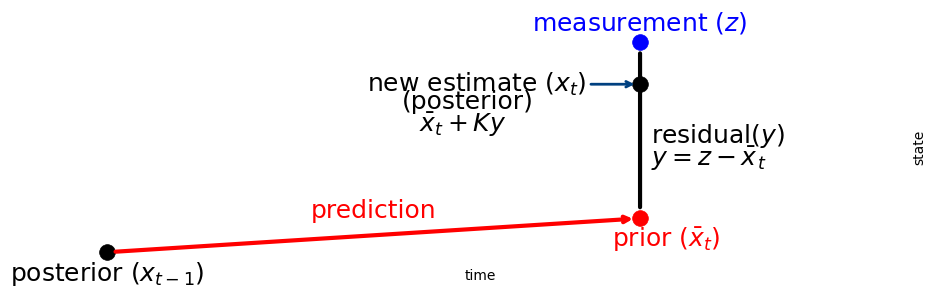

In [21]:
import kf_book.book_plots as book_plots
book_plots.show_residual_chart()

卡尔曼增益 $K$ 是一个比例因子，它沿着残差选择一个值。 这导致了 `update()` 和 `predict()` 的替代但等效的实现：

In [22]:
def update(prior, measurement):
    x, P = prior        # mean and variance of prior
    z, R = measurement  # mean and variance of measurement
    
    y = z - x        # residual
    K = P / (P + R)  # Kalman gain

    x = x + K*y      # posterior
    P = (1 - K) * P  # posterior variance
    return gaussian(x, P)

def predict(posterior, movement):
    x, P = posterior # mean and variance of posterior
    dx, Q = movement # mean and variance of movement
    x = x + dx
    P = P + Q
    return gaussian(x, P)

为什么我写成这种形式，为什么我选择了这些可怕的变量名？几个相关的原因。大多数书籍和论文都以这种形式介绍了卡尔曼滤波器。我从贝叶斯原理推导出过滤器并不是未知的，但它几乎没有被经常使用。替代推导自然会导致这种形式的方程。此外，多元卡尔曼滤波器的方程看起来几乎与这些方程完全相同。所以，你需要学习和理解它们。

名称“z”、“P”、“Q”和“R”从何而来？你将在本书的其余部分看到它们的使用。在文献中，$R$ 几乎普遍用于测量噪声，$Q$ 用于过程噪声，$P$ 用于状态的方差。使用 $z$ 进行测量很常见，尽管并不普遍。几乎你阅读的每一本书和论文都会使用这些变量名。习惯他们。

这也是考虑过滤的一种有效方式。这就是我们推理 g-h 过滤器的方式。它强调取残差 $y = \mu_z - \bar\mu$，找到卡尔曼增益作为我们在先验和测量中的不确定性的比率 $K = P/(P+R)$，并通过添加计算后验$Ky$ 到先前的。

贝叶斯方面在这种形式中被掩盖了，因为我们将可能性乘以先验。两种观点是等价的，因为数学是相同的。我选择贝叶斯方法是因为我认为它对概率推理提供了更直观但更深刻的理解。这种使用 $K$ 的替代形式可以深入理解所谓的*正交投影*方法。卡尔曼博士在发明这个过滤器时使用了这种推导，而不是贝叶斯推理。在接下来的几章中，您将对此有更多了解。

## Full Description of the Algorithm

回想一下我们用于 g-h 过滤器的图表：
<img src="./figs/residual_chart.png">

在本章中我们一直在做同样的事情。 卡尔曼滤波器进行预测，进行测量，然后在两者之间的某处形成新的估计。

**理解这一点非常重要**：本书中的每个过滤器都实现了相同的算法，只是具有不同的数学细节。 数学在后面的章节中可能会变得具有挑战性，但这个想法很容易理解。

重要的是要了解特定过滤器方程的详细信息，并了解方程正在计算*什么*以及*为什么*。 有大量的过滤器。 他们都使用不同的数学来实现相同的算法。 数学的选择会影响结果的质量以及可以表示的问题，但不会影响基本思想。

这是通用算法：

**初始化**

     1.初始化过滤器的状态
     2.初始化我们对状态的信念
    
**预测**

     1. 使用系统行为预测下一个时间步的状态
     2. 调整信念以解释预测中的不确定性
    
**更新**

     1.获得关于其准确性的测量和相关信念
     2.计算估计状态和测量之间的残差
     3.根据测量是否计算比例因子
     或者预测更准确
     4.在预测和测量之间设置状态
     关于比例因子
     5. 根据我们的确定程度更新对状态的信念
     在测量中
     
您将很难找到不适合这种形式的贝叶斯过滤算法。 有些过滤器不会包含某些方面，例如预测中的误差，而其他过滤器的计算方法会非常复杂，但这就是他们所做的。

单变量卡尔曼滤波器的方程为：

<u>Predict</u>

$\begin{array}{|l|l|l|}
\hline
\text{Equation} & \text{Implementation} & \text{Kalman Form}\\
\hline
 \bar x = x + f_x & \bar\mu = \mu + \mu_{f_x} & \bar x = x + dx\\
& \bar\sigma^2 = \sigma^2 + \sigma_{f_x}^2 & \bar P = P + Q\\
\hline
\end{array}$


<u>Update</u>

$\begin{array}{|l|l|l|}
\hline
\text{Equation} & \text{Implementation}& \text{Kalman Form}\\
\hline
 x = \| \mathcal L\bar x\| & y = z - \bar\mu & y = z - \bar x\\
 & K = \frac {\bar\sigma^2} {\bar\sigma^2 + \sigma_z^2} & K = \frac {\bar P}{\bar P+R}\\
 & \mu = \bar \mu + Ky & x = \bar x + Ky\\
 & \sigma^2 = \frac {\bar\sigma^2 \sigma_z^2} {\bar\sigma^2 + \sigma_z^2} & P = (1-K)\bar P\\
\hline
\end{array}$

## Comparison with g-h and discrete Bayes Filters

现在是了解这三个过滤器在我们如何建模错误方面的差异的好时机。 对于 g-h 滤波器，我们模拟了我们的测量值，如下图所示：

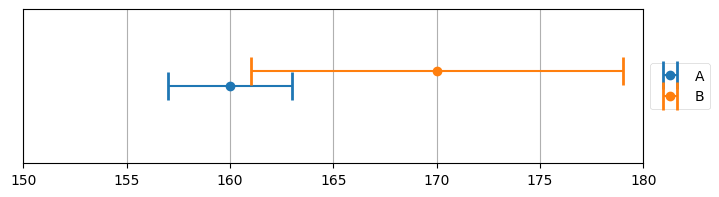

In [23]:
book_plots.plot_errorbars([(160, 3, 'A'), (170, 9, 'B')], xlims=(150, 180))

传感器 A 返回 160 的测量值，传感器 B 返回 170。条形图是 [*误差条*](https://en.wikipedia.org/wiki/Error_bar) - 它们说明了测量的可能误差范围。 因此，A 测量的实际值可能在 157 到 163 之间，而 B 测量的值在 161 到 179 之间。

我当时没有定义它，但这是一个 [*均匀分布*](https://en.wikipedia.org/wiki/Uniform_distribution_(continuous&#41;)。均匀分布为任何事件分配相等的概率 范围。根据该模型，传感器 A 读取 157、160 或 163 的可能性相同。超出这些范围的任何值的概率均为 0。

我们可以用高斯模型来模拟这种情况。 我将对传感器 A 使用 $\mathcal{N}(160, 3^2)$，对传感器 B 使用 $\mathcal{N}(170, 9^2)$。我在下面用制服绘制了这些 分布误差条进行比较。

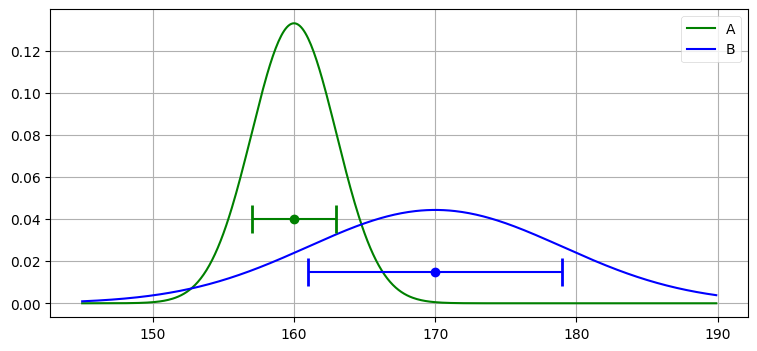

In [24]:
xs = np.arange(145, 190, 0.1)
ys = [stats.gaussian(x, 160, 3**2) for x in xs]
plt.plot(xs, ys, label='A', color='g')

ys = [stats.gaussian(x, 170, 9**2) for x in xs]
plt.plot(xs, ys, label='B', color='b')
plt.legend();
plt.errorbar(160, [0.04], xerr=[3], fmt='o', color='g', capthick=2, capsize=10)    
plt.errorbar(170, [0.015], xerr=[9], fmt='o', color='b', capthick=2, capsize=10);

使用均匀分布或高斯分布是一种建模选择。 两者都没有准确地描述现实。 在大多数情况下，高斯分布更真实。 大多数传感器更有可能返回接近被测量值的读数，而不太可能返回远离该值的读数。 高斯模型模拟了这种趋势。 相反，均匀分布假设在一个范围内的任何测量都是同样可能的。

现在让我们看看离散贝叶斯滤波器中使用的*离散分布*。 该模型将可能值的范围划分为离散范围，并为每个桶分配一个概率。 只要概率总和为 1，这种分配就可以完全是任意的。

让我们使用均匀分布、高斯分布和离散分布绘制一个传感器的数据。

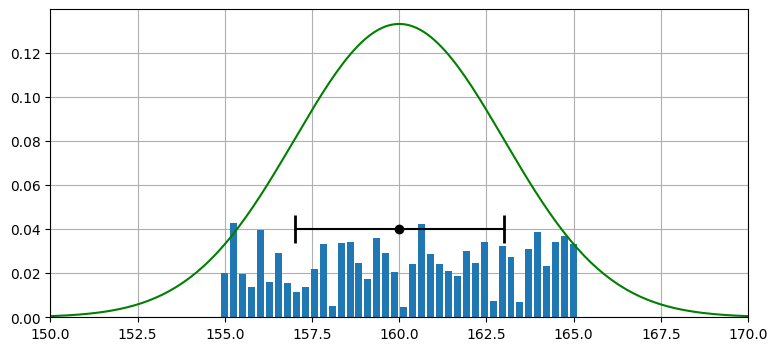

In [25]:
from random import random
xs = np.arange(145, 190, 0.1)
ys = [stats.gaussian(x, 160, 3**2) for x in xs]
belief = np.array([random() for _ in range(40)])
belief = belief / sum(belief)

x = np.linspace(155, 165, len(belief))
plt.gca().bar(x, belief, width=0.2)
plt.plot(xs, ys, label='A', color='g')
plt.errorbar(160, [0.04], xerr=[3], fmt='o', color='k', capthick=2, capsize=10)    
plt.xlim(150, 170);

我使用随机数形成离散分布来说明它可以对任意概率分布进行建模。这为其提供了巨大的力量。有了足够多的离散桶，无论多么复杂，我们都可以对任何传感器的误差特性进行建模。但这种力量带来了数学上的难解性。高斯相乘或相加需要两行数学运算，结果是另一个高斯。这种规律性使我们能够对过滤器的性能和行为进行强大的分析。乘以或添加离散分布需要循环数据，我们没有简单的方法来表征结果。基于离散分布分析滤波器的性能特征是极其困难的，甚至是不可能的。

这里没有“正确”的选择。在本书的后面，我们将介绍使用离散分布的*粒子过滤器*。这是一种非常强大的技术，因为它可以处理任意复杂的情况。这是以性能缓慢和分析分析阻力为代价的。

现在我们将忽略这些问题并在接下来的几章中回到使用高斯。随着我们的进步，您将了解在我们的数学模型中使用高斯的优势和局限性。

## Introduction to Designing a Filter

到目前为止，我们已经开发了用于位置传感器的滤波器。 我们现在已经习惯了这个问题，并且可能觉得没有能力为不同的问题实现卡尔曼滤波器。 老实说，这个演示文稿中仍然缺少相当多的信息。 以下章节将填补空白。 尽管如此，让我们通过为温度计设计和实现卡尔曼滤波器来感受一下。 温度计的传感器输出对应于被测温度的电压。 我们已经阅读了传感器的制造商规格，它告诉我们传感器显示出标准偏差为 0.13 伏的白噪声。

我们可以使用此功能模拟温度传感器测量：

In [26]:
def volt(voltage, std):
    return voltage + (randn() * std)

现在我们需要编写卡尔曼滤波器处理循环。与我们之前的问题一样，我们需要执行一个预测和更新的循环。传感步骤可能看起来很清楚 - 调用 volt() 来获取测量值，将结果传递给 update() 方法，但是预测步骤呢？我们没有传感器来检测电压中的“运动”，并且在任何一小段时间内，我们都希望电压保持恒定。我们该如何处理？

一如既往，我们会相信数学。我们没有已知的运动，因此我们将其设置为零。然而，这意味着我们预测温度永远不会改变。如果这是真的，那么随着时间的推移，我们应该对我们的结果充满信心。一旦过滤器有足够的测量值，它将变得非常自信，它可以预测随后的温度，这将导致它忽略由于实际温度变化而产生的测量值。这称为 *smug* 过滤器，是您要避免的。因此，我们将在我们的预测步骤中添加一些错误，以告诉滤波器不要忽略电压随时间的变化。在下面的代码中，我设置了 `process_var = .05**2`。这是每个时间步长上电压变化的预期变化。我选择这个值只是为了能够显示方差如何通过更新和预测步骤发生变化。对于真正的传感器，您可以将此值设置为您期望的实际变化量。例如，如果它是用于测量房屋内环境空气温度的温度计，这将是一个非常小的数字，而如果这是一个化学反应室中的热电偶，则该数字将是一个很大的数字。我们将在后面的章节中详细介绍如何选择实际值。

让我们看看发生了什么。

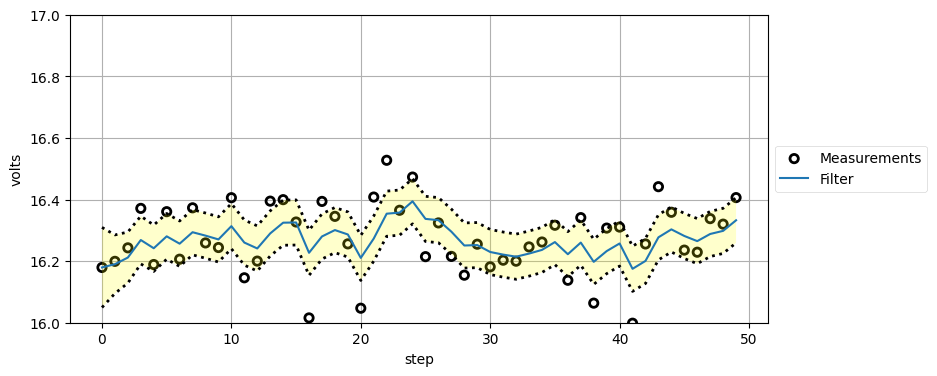

Variance converges to 0.005


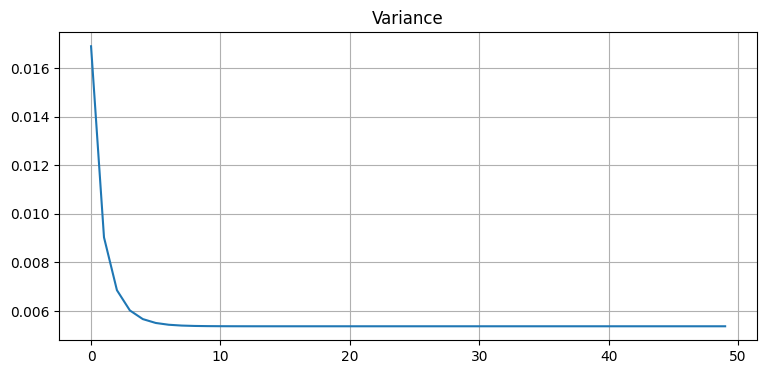

In [27]:
temp_change = 0
voltage_std = .13
process_var = .05**2
actual_voltage = 16.3

x = gaussian(25., 1000.) # initial state
process_model = gaussian(0., process_var)

N = 50
zs = [volt(actual_voltage, voltage_std) for i in range(N)]
ps = []
estimates = []

for z in zs:
    prior = predict(x, process_model)
    x = update(prior, gaussian(z, voltage_std**2))

    # save for latter plotting
    estimates.append(x.mean)
    ps.append(x.var)

# plot the filter output and the variance
book_plots.plot_measurements(zs)
book_plots.plot_filter(estimates, var=np.array(ps))
book_plots.show_legend()
plt.ylim(16, 17)
book_plots.set_labels(x='step', y='volts')
plt.show()
    
plt.plot(ps)
plt.title('Variance')
print('Variance converges to {:.3f}'.format(ps[-1]))

第一个图显示了单个传感器测量值与滤波器输出的关系。尽管传感器中有很多噪音，我们还是很快发现了传感器的大致电压。在作者发表时我刚刚完成的运行中，滤波器的最后输出电压为 16.213 美元，与 `volt()` 函数使用的 16.4 美元非常接近。在其他运行中，我得到了越来越小的结果。

规格表就是它们听起来的样子 - 规格。基于正常的制造变化，任何单个传感器都会表现出不同的性能。值通常是最大值 - 规范保证性能至少会那么好。如果您购买昂贵的设备，通常会附带一张纸，显示您的特定项目的测试结果；这通常是非常值得信赖的。另一方面，如果这是一个便宜的传感器，它很可能在出售之前几乎没有接受过测试。制造商通常会测试其输出的一小部分，以验证样品是否在所需的性能范围内。如果您有一个关键应用，您需要仔细阅读规格表，以准确了解它们的范围是什么意思。他们是否保证他们的数量是最大值，或者说是 $3\sigma$ 错误率？每个项目都经过测试吗？方差是正态分布还是其他分布？最后，制造并不完美。您的零件可能有缺陷，与表上的性能不符。

例如，我正在查看气流传感器的数据表。有一个字段 *Repeatability*，其值为 $\pm 0.50\%$。这是高斯吗？有偏见吗？例如，可能重复性在低温下接近 $0.0\%$，而在高温下总是接近 $+0.50\%$。电气元件的数据表通常包含“典型性能特征”部分。这些用于捕获无法在表格中轻松传达的信息。例如，我正在查看显示 LM555 定时器的输出电压与电流的图表。三个曲线显示了不同温度下的性能。理想情况下，响应是线性的，但所有三条线都是弯曲的。这阐明了电压输出中的误差可能不是高斯误差——在此芯片的情况下，较高的温度会导致较低的电压输出，如果输入电流非常高，则电压输出是非常非线性的。

正如您可能猜到的那样，对传感器的性能进行建模是创建性能良好的卡尔曼滤波器的难点之一。

### Animation

对于那些在浏览器中阅读这篇文章的人来说，这里有一个显示过滤器工作的动画。 如果您不使用浏览器，您可以在以下位置看到此图 <img src='./animations/05_volt_animate.gif'/>

动画中的顶部图为预测的下一个电压绘制一条绿线，然后为实际测量绘制一条红色“+”，绘制一条浅红色线以显示残差，然后为滤波器的输出绘制一条蓝线。您可以看到，当过滤器启动时，所做的校正非常大，但仅在几次更新后，即使测量距离很远，过滤器也只会少量调整其输出。

下图显示了滤波器创新时的高斯信念。当滤波器启动时，高斯曲线以 25 为中心，这是我们对电压的初始猜测，由于我们最初的不确定性，它非常宽且短。但随着滤波器的创新，高斯分布迅速移动到大约 16.0 并变得更高，这反映了滤波器对其电压估计值的信心日益增强。您还会注意到，高斯的高度会稍微上下反弹。如果您仔细观察，您会发现高斯在预测步骤期间变得更短且更分散，并且随着滤波器包含另一个测量值而变得更高和更窄。

根据 g-h 过滤器来考虑这个动画。在每一步，g-h 滤波器都会进行预测，进行测量，计算残差（预测与测量之间的差异），然后根据缩放因子 $g$ 在残差线上选择一个点。卡尔曼滤波器的作用完全相同，只是比例因子 $g$ 随时间变化。随着滤波器对其状态的信心越来越大，比例因子有利于滤波器的预测而不是测量。

## Example: Extreme Amounts of Noise

使用狗过滤器时，我没有在信号中加入很多噪声，我“猜测”狗在位置 0。过滤器在现实世界条件下的表现如何？ 我将首先在 RFID 传感器中注入更多噪声，同时将过程方差保持在 2 m$^2$。 我将注入大量的噪音——噪音显然淹没了实际测量。 如果传感器的标准偏差为 300 米，您的直觉对过滤器的性能有何看法？ 换言之，1.0 m 的实际位置可能报告为 287.9 m，或 -589.6 m，或大致该范围内的任何其他数字。 在向下滚动之前考虑一下。

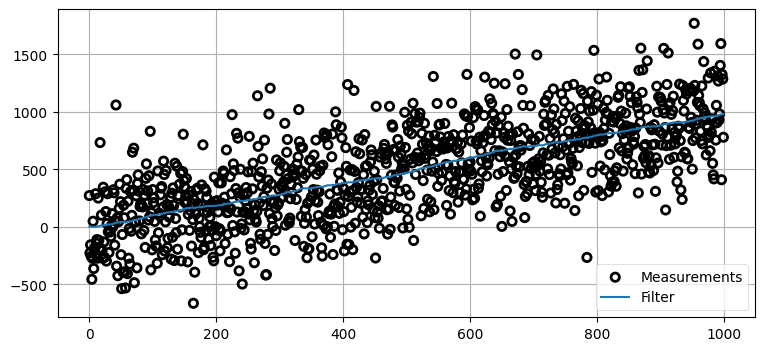

In [28]:
sensor_var = 300.**2
process_var = 2.
process_model = gaussian(1., process_var)
pos = gaussian(0., 500.)
N = 1000
dog = DogSimulation(pos.mean, 1., sensor_var, process_var)
zs = [dog.move_and_sense() for _ in range(N)]
ps = []

for i in range(N):
    prior = predict(pos, process_model)    
    pos = update(prior, gaussian(zs[i], sensor_var))
    ps.append(pos.mean)

book_plots.plot_measurements(zs, lw=1)
book_plots.plot_filter(ps)
plt.legend(loc=4);

在此示例中，噪声非常大，但滤波器仍输出几乎直线！ 这是一个惊人的结果！ 您认为造成这种表现的原因可能是什么？

我们得到一条几乎直线，因为我们的过程误差很小。 一个小的过程误差告诉过滤器预测是非常可信的，并且预测是一条直线，所以过滤器输出一条几乎是直线的。

## Example: Incorrect Process Variance

最后一个过滤器看起来棒极了！ 为什么我们不将过程方差设置得非常低，因为它保证了结果将是直接和平滑的？

过程方差告诉过滤器系统随时间变化的程度。 如果您通过人为地将此数字设置为低来欺骗过滤器，则过滤器将无法对正在发生的变化做出反应。 让狗在每个时间步增加一点速度，看看过滤器在 0.001 m$^2$ 的过程方差下的表现。

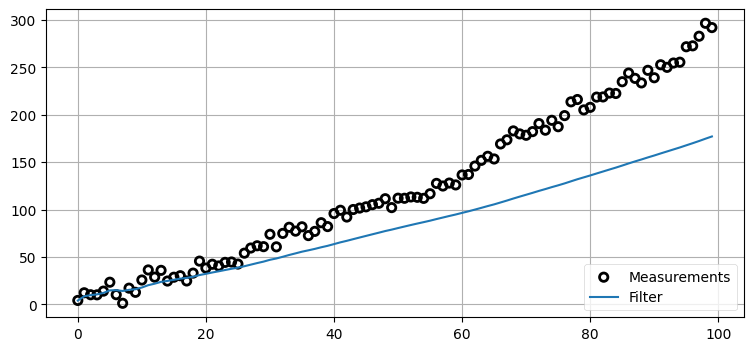

In [29]:
sensor_var = 20.
process_var = .001
process_model = gaussian(1., process_var)
pos = gaussian(0., 500.)
N = 100
dog = DogSimulation(pos.mean, 1, sensor_var, process_var*10000)
zs, ps = [], []
for _ in range(N):
    dog.velocity += 0.04
    zs.append(dog.move_and_sense())

for z in zs:
    prior = predict(pos, process_model)    
    pos = update(prior, gaussian(z, sensor_var))
    ps.append(pos.mean)

book_plots.plot_measurements(zs, lw=1)
book_plots.plot_filter(ps)
plt.legend(loc=4)

很容易看出滤波器没有正确响应测量值。 测量结果清楚地表明狗正在改变速度，但过滤器被告知它的预测几乎是完美的，所以它几乎完全忽略了它们。 我鼓励您调整狗的运动量与过程差异。 我们还将在后面的章节中更多地研究这个主题。 关键是要认识到数学要求方差正确描述您的系统。 过滤器不会“注意到”它与测量结果不同并自行纠正。 它根据先验和测量的方差计算卡尔曼增益，并根据哪个更准确形成估计。

## Example: Bad Initial Estimate

现在让我们看看当我们对位置做出错误的初始估计时的结果。 为了避免模糊结果，我将传感器方差减小到 30，但将初始位置设置为 1000 米。 过滤器能否从 1000 米错误中恢复？

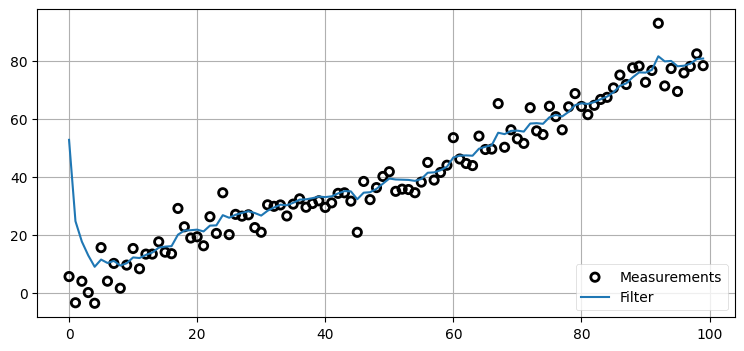

In [23]:
sensor_var = 5.**2
process_var = 2.
pos = gaussian(1000., 500.)
process_model = gaussian(1., process_var)
N = 100
dog = DogSimulation(0, 1, sensor_var, process_var)
zs = [dog.move_and_sense() for _ in range(N)]
ps = []

for z in zs:
    prior = predict(pos, process_model)    
    pos = update(prior, gaussian(z, sensor_var))
    ps.append(pos.mean)

book_plots.plot_measurements(zs, lw=1)
book_plots.plot_filter(ps)
plt.legend(loc=4);

答案是肯定的！ 因为仅在第一步之后我们就相对确定了我们对传感器的信念（$\sigma^2=5^2$），所以我们将位置估计从 1000 m 更改为大约 50 m。 在另外 5-10 次测量之后，我们已经收敛到正确的值。 这就是我们如何解决最初猜测的先有鸡还是先有蛋的问题。 在实践中，我们可能会将传感器的第一个测量值指定为初始值，但是您可以看到，如果我们疯狂地猜测初始条件，这并不重要 - 只要选择滤波器方差，卡尔曼滤波器仍然会收敛 匹配实际过程和测量差异。

## Example: Large Noise and Bad Initial Estimate

两全其美，大噪音和糟糕的初始估计怎么办？

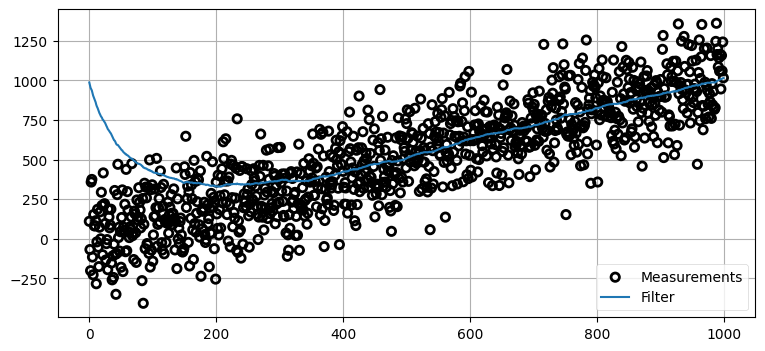

In [30]:
sensor_var = 30000.
process_var = 2.
pos = gaussian(1000., 500.)
process_model = gaussian(1., process_var)

N = 1000
dog = DogSimulation(0, 1, sensor_var, process_var)
zs = [dog.move_and_sense() for _ in range(N)]
ps = []

for z in zs:
    prior = predict(pos, process_model) 
    pos = update(prior, gaussian(z, sensor_var))
    ps.append(pos.mean)

book_plots.plot_measurements(zs, lw=1)
book_plots.plot_filter(ps)
plt.legend(loc=4);

这次过滤器挣扎。 请注意，前面的示例仅计算了 100 次更新，而此示例使用了 1000 次。在我看来，过滤器需要 400 次左右的迭代才能变得合理准确，但在结果良好之前可能超过 600 次。 卡尔曼滤波器很好，但我们不能指望奇迹。 如果我们有非常嘈杂的数据和非常糟糕的初始条件，那么这就是最好的。

最后，让我们实现使用第一次测量作为初始位置的建议。

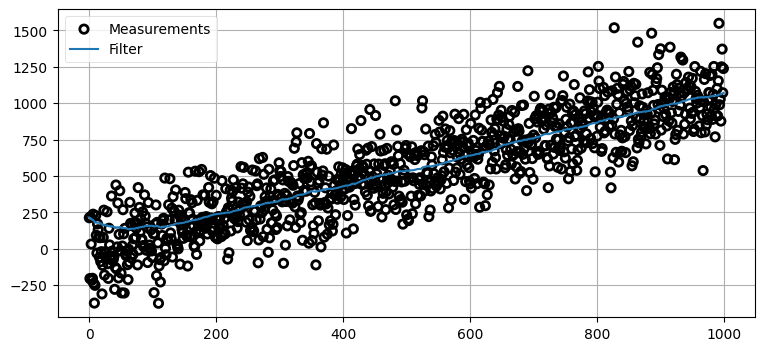

In [31]:
sensor_var = 30000.
process_var = 2.
process_model = gaussian(1., process_var)
N = 1000
dog = DogSimulation(0, 1, sensor_var, process_var)
zs = [dog.move_and_sense() for _ in range(N)]

pos = gaussian(zs[0], 500.)
ps = []
for z in zs:
    prior = predict(pos, process_model) 
    pos = update(prior, gaussian(z, sensor_var))
    ps.append(pos.mean)

book_plots.plot_measurements(zs, lw=1)
book_plots.plot_filter(ps)
plt.legend(loc='best');

这个简单的改变显着改善了结果。 在某些运行中，需要 200 次左右的迭代才能找到一个好的解决方案，但在其他运行中，它收敛得非常快。 这一切都取决于第一次测量中的噪声量。 大量噪声导致初始估计远离狗的位置。

200 次迭代可能看起来很多，但我们注入的噪声量确实是巨大的。 在现实世界中，我们使用温度计、激光测距仪、GPS 卫星、计算机视觉等传感器。 这些例子中没有一个有很大的错误。 便宜温度计的合理方差可能是 0.2 C$^{\circ 2}$，而我们的代码使用 30,000 C$^{\circ 2}$。

## Exercise: Interactive Plots

使用 Jupyter Notebook 的动画功能实现卡尔曼滤波器，允许您使用滑块实时修改各种常量。 请参阅 **Gaussians** 章节中的 **Interactive Gaussians** 部分，了解如何执行此操作。 您将使用 `interact()` 函数来调用计算和绘图函数。 传入 `interact()` 的每个参数都会自动获取为其创建的滑块。 我为此编写了样板； 您填写所需的代码。

In [25]:
from ipywidgets import interact
from kf_book.book_plots import FloatSlider

def plot_kalman_filter(start_pos, 
                       sensor_noise, 
                       velocity, 
                       process_noise):
    plt.figure();
    # your code goes here

interact(plot_kalman_filter,
         start_pos=(-10, 10), 
         sensor_noise=FloatSlider(value=5, min=0, max=100), 
         velocity=FloatSlider(value=1, min=-2., max=2.), 
         process_noise=FloatSlider(value=5, min=0, max=100.));

interactive(children=(IntSlider(value=0, description='start_pos', max=10, min=-10), FloatSlider(value=5.0, con…

### Solution

下面是一种可能的解决方案。 我们有用于起始位置的滑块、传感器中的噪声量、我们在每个时间步中移动的量以及存在多少移动误差。 过程噪音可能是最不清晰的——它模拟了狗在每个时间步偏离路线的程度，因此我们将其添加到狗在每一步的位置中。 我设置了随机数生成器种子，以便每次重绘都使用相同的随机数，从而允许我们在移动滑块时比较图形。

In [26]:
from numpy.random import seed 
from ipywidgets import interact

def plot_kalman_filter(start_pos, 
                       sensor_noise, 
                       velocity,
                       process_noise):
    N = 20
    zs, ps = [], []   
    seed(303)
    dog = DogSimulation(start_pos, velocity, sensor_noise, process_noise)
    zs = [dog.move_and_sense() for _ in range(N)]
    pos = gaussian(0., 1000.) # mean and variance
    process_model = gaussian(velocity, process_noise)
    
    for z in zs:    
        pos = predict(pos, process_model)
        pos = update(pos, gaussian(z, sensor_noise))
        ps.append(pos.mean)

    plt.figure()
    plt.plot(zs, c='k', marker='o', linestyle='', label='measurement')
    plt.plot(ps, c='#004080', alpha=0.7, label='filter')
    plt.legend(loc=4);

interact(plot_kalman_filter,
         start_pos=(-10, 10), 
         sensor_noise=FloatSlider(value=5, min=0., max=100), 
         velocity=FloatSlider(value=1, min=-2., max=2.), 
         process_noise=FloatSlider(value=.1, min=0, max=40));

interactive(children=(IntSlider(value=0, description='start_pos', max=10, min=-10), FloatSlider(value=5.0, con…

## Exercise - Nonlinear Systems

我们的卡尔曼滤波器方程是线性的：

$$\begin{aligned}
\mathcal{N}(\bar\mu,\, \bar\sigma^2) &= \mathcal{N}(\mu,\, \sigma^2) + \mathcal{N}(\mu_\mathtt{move},\, \sigma^2_\mathtt{move})\\
\mathcal{N}(\mu,\, \sigma^2) &= \mathcal{N}(\bar\mu,\, \bar\sigma^2)  \times \mathcal{N}(\mu_\mathtt{z},\, \sigma^2_\mathtt{z})
\end{aligned}$$

你认为这个滤波器在非线性系统中效果好还是不好？

实现一个卡尔曼滤波器，它使用以下等式生成测量值

```python
for i in range(100):
    z = math.sin(i/3.) * 2
```

调整方差和初始位置，看看效果。 例如，一个非常糟糕的初始猜测的结果是什么？

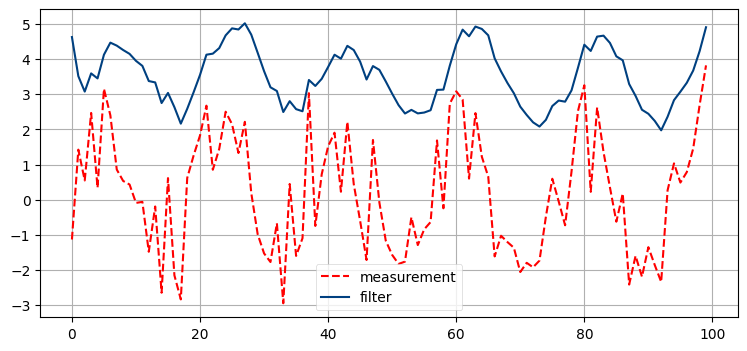

In [34]:
import math

sensor_var = 30.
process_var = 2.
pos = gaussian(100., 500.)
process_model = gaussian(1., process_var)

zs, ps = [], []

for i in range(100):
    pos = predict(pos, process_model)

    z = math.sin(i/3.)*2 + randn()*1.2
    zs.append(z)
    
    pos = update(pos, gaussian(z, sensor_var))
    ps.append(pos.mean)

plt.plot(zs, c='r', linestyle='dashed', label='measurement')
plt.plot(ps, c='#004080', label='filter')
plt.legend(loc='best');

### Discussion

这真糟糕！ 输出一点也不像正弦波，除了最粗暴的方式。 使用线性系统，我们可以在信号中添加大量噪声，仍然可以提取非常准确的结果，但在这里即使是适度的噪声也会产生非常糟糕的结果。

如果我们回忆一下 **g-h Filter** 章节，我们就可以理解这里发生了什么。 g-h 滤波器的结构要求滤波器输出在预测和测量之间选择一个值。 像这样的变化信号总是在加速，而我们的过程模型假设速度恒定，因此从数学上保证滤波器总是滞后输入信号。

从业者开始实施卡尔曼滤波器后不久，他们认识到非线性系统的性能不佳，并开始设计处理方法。 后面的章节专门讨论这个问题。

## Fixed Gain Filters

嵌入式计算机通常具有极其有限的处理器。 许多没有浮点电路。 这些简单的方程式会给芯片带来沉重的负担。 随着技术的进步，这不太正确，但是当您将购买数百万个处理器时，不要低估在处理器上少花一美元的价值。

在上面的例子中，滤波器的方差收敛到一个固定值。 如果测量和过程的方差是常数，这种情况总是会发生。 您可以通过运行模拟来确定方差收敛到什么来利用这一事实。 然后您可以将此值硬编码到您的过滤器中。 只要您将过滤器初始化为一个好的开始猜测（我建议使用第一次测量作为您的初始值），过滤器就会表现得非常好。 例如，狗跟踪过滤器可以简化为：

```python
def update(x, z):
    K = .13232  # experimentally derived Kalman gain
    y = z - x   # residual
    x = x + K*y # posterior
    return x
    
def predict(x):
    return x + vel*dt
```

我使用更新函数的卡尔曼增益形式来强调我们根本不需要考虑方差。 如果方差收敛到一个值，那么卡尔曼增益也会收敛。

## FilterPy's Implementation

FilterPy 实现了 `predict()` 和 `update()`。 它们不仅适用于本章开发的单变量案例，还适用于我们在后续章节中学习的更一般的多变量案例。 因此，它们的界面略有不同。 他们不把高斯当作元组，而是作为两个单独命名的变量。

`predict()` takes several arguments, but we will only need to use these four:

```python
predict(x, P, u, Q)
```
`x` 是系统的状态。 `P` 是系统的方差。 `u` 是过程引起的运动，`Q` 是过程中的噪声。 当您调用`predict()` 时，您将需要使用命名参数，因为大多数参数都是可选的。 `predict()` 的第三个参数是 **not** `u`。

这些可能会让你觉得变量名很糟糕。 他们是！ 正如我已经提到的，它们来自控制理论的悠久历史，您阅读的每篇论文或书籍都会使用这些名称。 所以，我们只需要习惯它。 拒绝记住它们意味着您将永远无法阅读文献。

让我们尝试一下状态 $\mathcal N(10, 3)$ 和运动 $\mathcal N(1, 4)$。 我们预计最终位置为 11 (10+1)，方差为 7 (3+4)。

In [35]:
import filterpy.kalman as kf
kf.predict(x=10., P=3., u=1., Q=4.)

(11.0, 7.0)

`update` 也有几个参数，但现在你会对这四个感兴趣：

```python
update(x, P, z, R)
```

和以前一样，`x` 和 `P` 是系统的状态和方差。 “z”是测量值，“R”是测量方差。 让我们执行最后一个预测语句来获取我们的先验，然后执行更新：

In [36]:
x, P = kf.predict(x=10., P=3., u=1., Q=2.**2)
print('%.3f' % x)

x, P = kf.update(x=x, P=P, z=12., R=3.5**2)
print('%.3f' % x, '%.3f' % P)

11.000
11.364 4.455


我给了它一个有很大差异的嘈杂测量，所以估计仍然接近 11 的先验。

最后一点。 我没有使用变量名“prior”作为预测步骤的输出。 我不会在本书的其余部分使用该变量名。 卡尔曼滤波器方程只使用 $\mathbf x$。 先验和后验都是系统的估计状态，前者是结合测量之前的估计，后者是结合测量之后的估计。

## Summary

我们在本章中描述的卡尔曼滤波器是我们接下来将学习的更通用滤波器的一种特殊的受限情况。大多数文本不讨论这种一维形式。但是，我认为这是一个重要的垫脚石。我们从 g-h 滤波器开始本书，然后实现了离散贝叶斯滤波器，现在实现了一维卡尔曼滤波器。我试图向您展示这些过滤器中的每一个都使用相同的算法和推理。我们将很快学习的卡尔曼滤波器的数学相当复杂，很难理解滤波器的基本简单性。这种复杂性带来了显着的好处：广义过滤器将明显优于本章中的过滤器。

本章需要时间来消化。要真正理解它，您可能需要多次阅读本章。我鼓励您更改代码中的各种常量并观察结果。说服自己，高斯函数很好地代表了狗在走廊中的位置、飞机在天空中的位置或化学反应室的温度的单峰信念。然后说服自己，乘以高斯确实确实从您先前的信念和新的测量中计算出一个新的信念。最后，说服自己，如果你正在测量运动，那么将高斯数加在一起会更新你的信念。

最重要的是，花足够的时间阅读**算法的完整描述**部分，以确保您了解算法以及它与 g-h 滤波器和离散贝叶斯滤波器的关系。这里只有一个“技巧”——在预测和测量之间选择一个值。每个算法都使用不同的数学来执行该技巧，但都使用相同的逻辑。